#Classificação de imagens de roupas

### Sobre o projeto

* Estudo introdutório sobre Deep Learning, TensorFlow e Keras.

* E-commerce fictício de roupas, as roupas à venda devem ser classificadas em categorias para facilitar as buscas dos clientes no site.

* **Dataset:** [Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist) que contém pequenas imagens (28x28) de roupas, associadas a 10 classes.

* **Referência:** Estudo desenvolvido acompanhando o curso [Deep Learning parte 1: Keras](https://cursos.alura.com.br/course/deep-learning-introducao-com-keras), da Alura.

# Abertura do dataset e primeiras visualizações

## Fashion MNIST

In [1]:
import tensorflow
from tensorflow import keras

dataset = keras.datasets.fashion_mnist

In [2]:
# retorna duas tuplas com conjuntos de treino, teste, e suas labels
((train_imgs, train_labels),(test_imgs, test_labels)) = dataset.load_data()

4422102/4422102 [==============================] - 0s 0us/step


In [3]:
print(f'Conjunto de treino possui {len(train_imgs)} imagens.')
print(f'Conjunto de teste possui {len(test_imgs)} imagens.')

Conjunto de treino possui 60000 imagens.
Conjunto de teste possui 10000 imagens.


In [4]:
print(train_imgs.shape)
print(test_imgs.shape)

(60000, 28, 28)
(10000, 28, 28)


## Classes

In [5]:
import numpy as np
np.unique(train_labels)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

* Os nomes das classes estão no Readme do dataset.

In [6]:
class_name = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

## Visualização de alguns itens

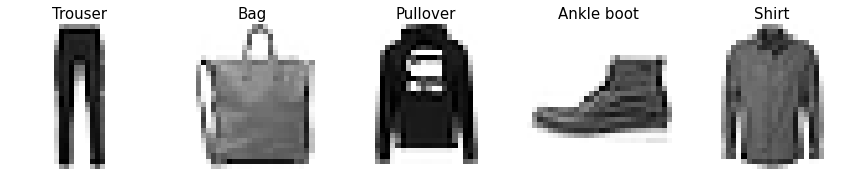

In [7]:
import random
import matplotlib.pyplot as plt
plt.rcParams['image.cmap'] = 'Greys'

fig, axs = plt.subplots(1, 5, figsize = (15, 25))

rand_ids = [random.randint(0, 60000) for i in range(5)]

for k, i in zip(range(0,5), rand_ids):
  axs[k].imshow(train_imgs[i])
  axs[k].axis('off')
  axs[k].set_title(class_name[train_labels[i]], fontsize = 15)

plt.show()

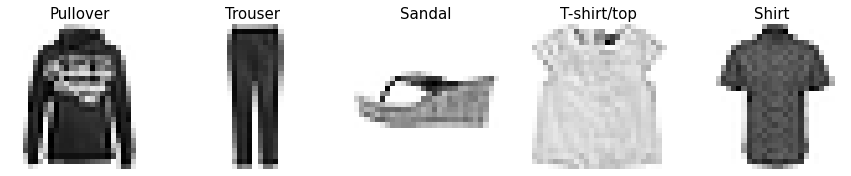

In [8]:
fig, axs = plt.subplots(1, 5, figsize = (15, 25))

rand_ids = [random.randint(0, 10000) for i in range(5)]

for k, i in zip(range(0,5), rand_ids):
  axs[k].imshow(test_imgs[i])
  axs[k].axis('off')
  axs[k].set_title(class_name[test_labels[i]], fontsize = 15)

plt.show()

# Funções de Ativação

![teste](https://miro.medium.com/max/720/1*ZafDv3VUm60Eh10OeJu1vw.webp)

## ReLu

* Todos os número negativos se tornam 0.
* A ReLu tem a possibilidade de desligar alguns neurônios.
* $a = z^+ = max(0, z)$
* É não-linear, essencial para separar mais de duas características em uma única função.

## SoftMax

* Usada da última camada.
* Atribui probabilidades de cada categoria estar correta.

* ### $a_j^{(L-1)} = \frac{exp(z_j^{(L-1)})}{∑_i exp(z_i^{(L-1)})}$

  * (L-1) ⟶ camada anterior.
  * a > 0, por do exponencial.
  * O somatório de todas as probabilidades é 1, 100%.

# Construção do Modelo

* Modelo >> entrada > processamento > saída

* Na primeira camada, Camada 0, a imagem será "achatada" para um array de pixels de uma única dimensão.

* Na Camda 1, é feita a comunicação com a camada de entrada. Neste caso, será uma camada densa, totalmente conectada com a anterior.
  * No primneiro parâmetro, são definidos quantos neurônios estarão nesta camada.É interessante utilizar múltiplos de 2 por questão de processamento.
  * Deve ser definida também a função de ativação, que neste caso será a ReLu (https://www.tensorflow.org/api_docs/python/tf/nn/relu).

* Na Camada 2, de saída, terá o número de classificações do dataset e totalmente conectada.

In [9]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape = (28, 28)),               # camada 0, entrada
    keras.layers.Dense(256, activation = tensorflow.nn.relu),   # camada 1, escondida
    keras.layers.Dense(10, activation = tensorflow.nn.softmax)  # camada 2, saída
])

In [10]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy')

* O batch_size padrão é 32, por isso a quantidade que aparece no log não é o tamanho completo do dataset, mas sim esse valor dividido por 32. Todo o dataset é usado no treinamento, mas em grupos menores.

In [11]:
model.fit(train_imgs, train_labels)

1875/1875 [==============================] - 6s 3ms/step - loss: 3.6996


* O ideal é que a perda esteja o mais próximo de 0 possível.

# Redução de perda: Normalização

* Os pixels variam em um intervalo contínuo de 0 a 255.

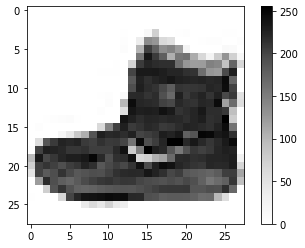

In [12]:
plt.imshow(train_imgs[0])
plt.colorbar()

* O valores serão normalizados para um intervalo de 0 a 1.

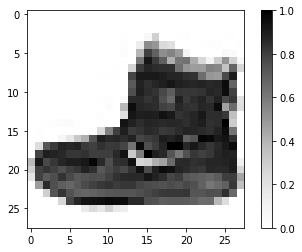

In [13]:
train_imgs = train_imgs/255.0

plt.imshow(train_imgs[0])
plt.colorbar()

# 2º Modelo: Valores normalizados [0, 1]

In [14]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape = (28, 28)),
    keras.layers.Dense(256, activation = tensorflow.nn.relu),
    keras.layers.Dense(10, activation = tensorflow.nn.softmax)
])

model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy')
model.fit(train_imgs, train_labels)

1875/1875 [==============================] - 6s 3ms/step - loss: 0.4872


* Na execução desta observação, a perda foi reduzida de 4.4171 para 0.4825.

* Reduzir a amplitude numérica que a rede precisou processar ajudou muito a evitar perda de informação.

* As gradações das imagens se mantiveram, a roupa usada como exemplo anteriormente continuou sendo visualmente identificável, e ainda houve melhoria no modelo.

# Redução de perda: Reestruturação das camadas escondidas

* Da segunda camada para a camada de saída há conexões de 256 para 10. 

* A ideia do próximo passo é afunilar estas conexões criando uma camada internediária e verificar se a perda é reduzida.

## Segunda camada escondida: 128 neurônios

In [15]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape = (28, 28)),               # camada de entrada
    keras.layers.Dense(256, activation = tensorflow.nn.relu),   # primeira camada escondida
    keras.layers.Dense(128, activation = tensorflow.nn.relu),   # nova camda escondida, segunda camada
    keras.layers.Dense(10, activation = tensorflow.nn.softmax)  # camada de saída
])

model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy')
model.fit(train_imgs, train_labels)

1875/1875 [==============================] - 7s 4ms/step - loss: 0.4746


* Na execução desta observação, a perda foi reduzida de 0.4825 para 0.4777.

## Terceira camada escondida: 64 neurônios

In [16]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape = (28, 28)),
    keras.layers.Dense(256, activation = tensorflow.nn.relu),
    keras.layers.Dense(128, activation = tensorflow.nn.relu),
    keras.layers.Dense(64, activation = tensorflow.nn.relu),    # terceira camada escondida
    keras.layers.Dense(10, activation = tensorflow.nn.softmax)
])

model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy')
model.fit(train_imgs, train_labels)

1875/1875 [==============================] - 7s 4ms/step - loss: 0.4893


* Na execução desta observação, a perda foi incrementada de 0.4777 para 0.4854.

* Neste caso de estudo, o aumento do tempo de execução foi irrelevante.

* Aumentar a quantidade de camadas escondidas, tornando a rede mais profunda, nem sempre trará benefícios para o modelo, além de poder aumentar significativamente o tempo de execução em modelos de aplicação real.

* Tanto a quantidade de neurônios quanto as funções de ativação precisarão de uma exploração, um processo mais subjetivo do que exato.

# 3º Modelo: Normalização e 2 camadas escondidas

In [17]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape = (28, 28)),
    keras.layers.Dense(256, activation = tensorflow.nn.relu),
    keras.layers.Dense(128, activation = tensorflow.nn.relu),
    keras.layers.Dense(10, activation = tensorflow.nn.softmax)
])

model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy')
model.fit(train_imgs, train_labels)

1875/1875 [==============================] - 7s 3ms/step - loss: 0.4756


# Redução de perda: Quantidade de épocas

* Épocas são os contatos que o modelo tem com o dataset no processo de aprendizagem, em que os ajustes de pesos das conexões são feitas entre os neurônios.

* A seguir, as quantidades de épocas serão alteradas para análise da sua influência na perda.

* O tempo de execução terá um aumento linear, diretamente proporcional à execução com somento uma época.

In [18]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape = (28, 28)),
    keras.layers.Dense(256, activation = tensorflow.nn.relu),
    keras.layers.Dense(128, activation = tensorflow.nn.relu),
    keras.layers.Dense(10, activation = tensorflow.nn.softmax)
])

model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy')
model.fit(train_imgs, train_labels, epochs = 5)

Epoch 1/5
1875/1875 [==============================] - 9s 5ms/step - loss: 0.4771
Epoch 2/5
1875/1875 [==============================] - 8s 4ms/step - loss: 0.3596
Epoch 3/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.3248
Epoch 4/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.3016
Epoch 5/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.2813


* A perda foi diminindo gradativamente, mas mesmo neste dataset de estudo o aumento de tempo já foi perceptível.

# 4º Modelo: Normalização, 2 camadas escondidas, 5 épocas

In [19]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape = (28, 28)),
    keras.layers.Dense(256, activation = tensorflow.nn.relu),
    keras.layers.Dense(128, activation = tensorflow.nn.relu),
    keras.layers.Dense(10, activation = tensorflow.nn.softmax)
])

model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
model.fit(train_imgs, train_labels, epochs = 5)

Epoch 1/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.4785 - accuracy: 0.8267
Epoch 2/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.3578 - accuracy: 0.8690
Epoch 3/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.3226 - accuracy: 0.8816
Epoch 4/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.3023 - accuracy: 0.8875
Epoch 5/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.2832 - accuracy: 0.8933


# Métrica de avaliação: Acurácia

* A acurácia irá medir o quanto o modelo está acertando.

* O ideal é que, à medida que o modelo é reestruturado, a perda diminua e a acurácia aumente.

In [20]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape = (28, 28)),
    keras.layers.Dense(256, activation = tensorflow.nn.relu),
    keras.layers.Dense(128, activation = tensorflow.nn.relu),
    keras.layers.Dense(10, activation = tensorflow.nn.softmax)
])

model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
model.fit(train_imgs, train_labels, epochs = 5)

Epoch 1/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.4747 - accuracy: 0.8285
Epoch 2/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.3610 - accuracy: 0.8698
Epoch 3/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.3231 - accuracy: 0.8811
Epoch 4/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.3011 - accuracy: 0.8870
Epoch 5/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.2831 - accuracy: 0.8939


* A acurácia aumentou de acordo com a quantidade de épocas executadas.

# Testes do Modelo

## Elemento a elemento

* Sobre o modelo com as aletrações: imagens normalizadas, segunda camada escondida e 5 épocas.

In [21]:
testes = model.predict(test_imgs)

313/313 [==============================] - 1s 2ms/step


In [22]:
testes[0]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.99999994],
      dtype=float32)

In [23]:
np.argmax(testes[0])

9

* A Softmax, usada na camada de saída, retorna a probabilidade de uma entrada pertencer a cada categoria.

* No primeiro item do dataset, demonstrado acima, foi calculada uma probabilidade de quase 100% da imagem representar um item da última classe.

In [24]:
print(f'Resultado do teste: {np.argmax(testes[0])}')
print(f'Número da imagem de teste: {test_labels[0]}')

Resultado do teste: 9
Número da imagem de teste: 9


## Evaluate

* 1º Resultados: Perda do teste
* 2º Resultado: Acurácia do teste

In [25]:
test_loss, test_accuracy = model.evaluate(test_imgs, test_labels)
print(f'Perda: {test_loss}')
print(f'Acuráci: {test_accuracy}')

313/313 [==============================] - 1s 2ms/step - loss: 49.0579 - accuracy: 0.8671
Perda: 49.057899475097656
Acuráci: 0.8671000003814697


In [26]:
test_imgs_normalized = test_imgs/255

test_loss, test_accuracy = model.evaluate(test_imgs_normalized, test_labels)
print(f'Perda: {test_loss}')
print(f'Acuráci: {test_accuracy}')

313/313 [==============================] - 1s 2ms/step - loss: 0.3614 - accuracy: 0.8658
Perda: 0.3614228367805481
Acuráci: 0.8658000230789185


## Conjunto de Validação

* Com a definição do validation_split, o treinamento passa a separar um conjunto para validação do modelo.

* Os valores de perda e acurácia da validação são retornados junto com os do treino.

In [94]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape = (28, 28)),
    keras.layers.Dense(256, activation = tensorflow.nn.relu),
    keras.layers.Dense(128, activation = tensorflow.nn.relu),
    keras.layers.Dense(10, activation = tensorflow.nn.softmax)
])

model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
historico = model.fit(train_imgs, train_labels, epochs = 5, validation_split = 0.2)

Epoch 1/5
1500/1500 [==============================] - 8s 5ms/step - loss: 0.4944 - accuracy: 0.8227 - val_loss: 0.3827 - val_accuracy: 0.8597
Epoch 2/5
1500/1500 [==============================] - 6s 4ms/step - loss: 0.3700 - accuracy: 0.8639 - val_loss: 0.3722 - val_accuracy: 0.8617
Epoch 3/5
1500/1500 [==============================] - 9s 6ms/step - loss: 0.3346 - accuracy: 0.8767 - val_loss: 0.3438 - val_accuracy: 0.8758
Epoch 4/5
1500/1500 [==============================] - 6s 4ms/step - loss: 0.3065 - accuracy: 0.8857 - val_loss: 0.3326 - val_accuracy: 0.8768
Epoch 5/5
1500/1500 [==============================] - 6s 4ms/step - loss: 0.2880 - accuracy: 0.8920 - val_loss: 0.3296 - val_accuracy: 0.8822


# Gráficos de Acurácia e Perda

In [ ]:
def plot_accuracy_loss(historico):
  fig, axs = plt.subplots(1, 2, figsize = (12, 5))

  axs[0].set_title('Acurácia por épocas', fontsize = 15)
  axs[0].set(xlabel = 'épocas', ylabel = 'perda')
  axs[0].plot(historico.history['accuracy'])
  axs[0].plot(historico.history['val_accuracy'])

  axs[1].set_title('Perda por épocas', fontsize = 15)
  axs[1].set(xlabel = 'épocas', ylabel = 'perda')
  axs[1].plot(historico.history['loss'])
  axs[1].plot(historico.history['val_loss'])

  plt.show()

## Análise de 5 épocas

In [28]:
historico.history

{'loss': [0.498549222946167,
  0.3717551529407501,
  0.33270883560180664,
  0.3089047372341156,
  0.2884579002857208],
 'accuracy': [0.8202083110809326,
  0.8634583353996277,
  0.8778541684150696,
  0.8856250047683716,
  0.8920416831970215],
 'val_loss': [0.39552026987075806,
  0.3732278347015381,
  0.3360172212123871,
  0.33688145875930786,
  0.32751280069351196],
 'val_accuracy': [0.859499990940094,
  0.8654999732971191,
  0.8776666522026062,
  0.8784166574478149,
  0.8829166889190674]}

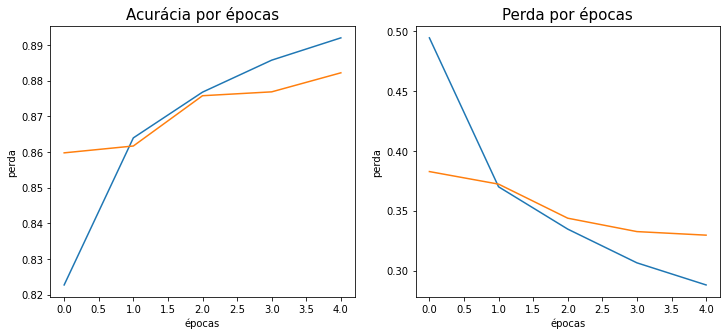

In [95]:
plot_accuracy_loss(historico)

* A acurácia aumentou no decorrer das 5 épocas. Portanto, seguiu como desejado.

* A perda diminuiu no decorrer das 5 épocas. Também seguiu como desejado.

## Análise de 10 épocas

In [96]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape = (28, 28)),
    keras.layers.Dense(256, activation = tensorflow.nn.relu),
    keras.layers.Dense(128, activation = tensorflow.nn.relu),
    keras.layers.Dense(10, activation = tensorflow.nn.softmax)
])

model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
historico = model.fit(train_imgs, train_labels, epochs = 10, validation_split = 0.2)

Epoch 1/10
1500/1500 [==============================] - 9s 6ms/step - loss: 0.4933 - accuracy: 0.8245 - val_loss: 0.3962 - val_accuracy: 0.8555
Epoch 2/10
1500/1500 [==============================] - 7s 5ms/step - loss: 0.3693 - accuracy: 0.8645 - val_loss: 0.3614 - val_accuracy: 0.8684
Epoch 3/10
1500/1500 [==============================] - 7s 5ms/step - loss: 0.3365 - accuracy: 0.8736 - val_loss: 0.3473 - val_accuracy: 0.8773
Epoch 4/10
1500/1500 [==============================] - 7s 5ms/step - loss: 0.3101 - accuracy: 0.8848 - val_loss: 0.3170 - val_accuracy: 0.8846
Epoch 5/10
1500/1500 [==============================] - 7s 5ms/step - loss: 0.2901 - accuracy: 0.8919 - val_loss: 0.3358 - val_accuracy: 0.8796
Epoch 6/10
1500/1500 [==============================] - 7s 5ms/step - loss: 0.2725 - accuracy: 0.8968 - val_loss: 0.3179 - val_accuracy: 0.8876
Epoch 7/10
1500/1500 [==============================] - 7s 5ms/step - loss: 0.2610 - accuracy: 0.9008 - val_loss: 0.3295 - val_accuracy:

### Acurácia

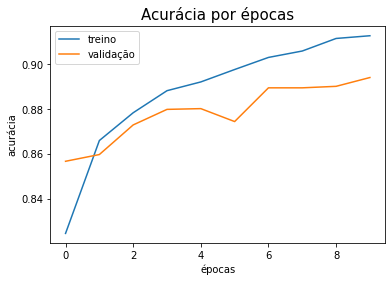

In [32]:
plt.plot(historico.history['accuracy'])
plt.plot(historico.history['val_accuracy'])

plt.title('Acurácia por épocas', fontsize = 15)
plt.xlabel('épocas')
plt.ylabel('acurácia')
plt.legend(['treino', 'validação'])
plt.show()

* A Acurácia do treino sobe de forma consistente, mas a de validação não só não consegue aumentar o suficiente para acompanhá-la como oscila no decorrer das épocas.

### Perda

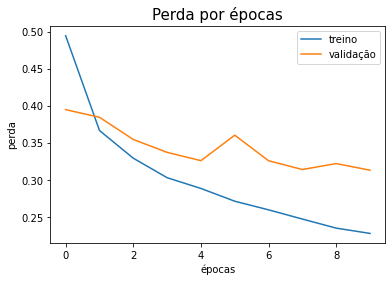

In [33]:
plt.plot(historico.history['loss'])
plt.plot(historico.history['val_loss'])

plt.title('Perda por épocas', fontsize = 15)
plt.xlabel('épocas')
plt.ylabel('perda')
plt.legend(['treino', 'validação'])
plt.show()

* Algo semelhante acontece com os valores de perda, a validação não consegue acompanhar o treino.

* Os dois gráficos sugereme o modelo está sofrendo um Overfitting, ou seja, está tão especializado nos padrões das imagens de treinamento que não consegue interpretar novas imagens, do conjunto de validação.

* Para evitar o oferfitting, pode-se manter a quantidade de épocas no intervalo em que os resultados estão mais estáveis. Onde a tendência da perda e da acurácia estão favoráveis no treino e os resultados na validação ainda estão próximos.

* Neste caso, entre [4, 6]. Será mantido o 4º modelo.

# Mais alterações nas camadas escondidas

## Dropout

* Irá inativar algumas ligações entre duas camadas, como se os neurônios estivessem inativos. Recebe uma porcentagem de ligações que serão desligadas.

* Pode ser considerado uma Normalização.

In [97]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape = (28, 28)),
    keras.layers.Dense(256, activation = tensorflow.nn.relu),
    keras.layers.Dense(128, activation = tensorflow.nn.relu),
    keras.layers.Dropout(0.2),  # nova camada escondida
    keras.layers.Dense(10, activation = tensorflow.nn.softmax)
])

model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
historico = model.fit(train_imgs, train_labels, epochs = 5, validation_split = 0.2)

Epoch 1/5
1500/1500 [==============================] - 8s 5ms/step - loss: 0.5200 - accuracy: 0.8135 - val_loss: 0.4011 - val_accuracy: 0.8528
Epoch 2/5
1500/1500 [==============================] - 7s 4ms/step - loss: 0.3825 - accuracy: 0.8578 - val_loss: 0.3829 - val_accuracy: 0.8620
Epoch 3/5
1500/1500 [==============================] - 7s 5ms/step - loss: 0.3449 - accuracy: 0.8710 - val_loss: 0.3465 - val_accuracy: 0.8741
Epoch 4/5
1500/1500 [==============================] - 7s 5ms/step - loss: 0.3206 - accuracy: 0.8814 - val_loss: 0.3521 - val_accuracy: 0.8763
Epoch 5/5
1500/1500 [==============================] - 7s 4ms/step - loss: 0.3017 - accuracy: 0.8870 - val_loss: 0.3317 - val_accuracy: 0.8787


### Gráficos de Validação

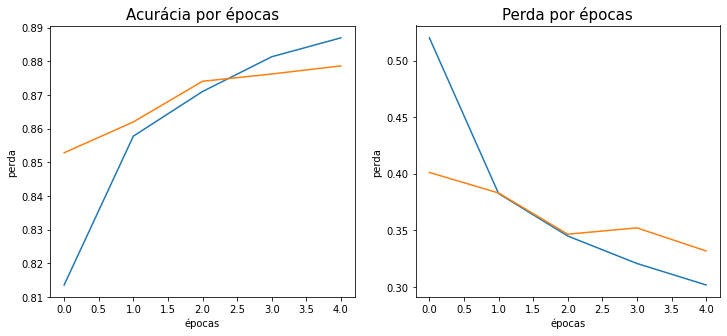

In [98]:
plot_accuracy_loss(historico)

* O comportamento das curvas de validação melhoraram em comparação com o modelo sem Dropout. Apesar dos resultados de treino serem um pouco piores, a perda e acurácia da validação estão melhores.

# Salvando e utilizando modelo treinado

In [99]:
model.save('model.h5')

In [100]:
from tensorflow.keras.models import load_model

saved_model = load_model('model.h5')

In [101]:
tests = saved_model.predict(test_imgs_normalized)
print(f'Resultado do teste: {np.argmax(tests[0])}')
print(f'Rótulo da imagem: {test_labels[0]}')

313/313 [==============================] - 1s 2ms/step
Resultado do teste: 9
Rótulo da imagem: 9


# Análises sobre o modelo e teoria

* A partir daqui, foram feitos alguns exercícios do curso para fixar conceitos relacionados a Redes Neurais. Não necessariamente têm uma aplicação prática.

## Sumário, descrição das camadas

In [102]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_13 (Flatten)        (None, 784)               0         
                                                                 
 dense_38 (Dense)            (None, 256)               200960    
                                                                 
 dense_39 (Dense)            (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_40 (Dense)            (None, 10)                1290      
                                                                 
Total params: 235,146
Trainable params: 235,146
Non-trainable params: 0
_________________________________________________________________


* O Param # mostra a quantidade de parâmetros que são considerados na camada.
  * 1º há apenas o achatamento, o valor ficou 0
  * 2º (784 (achatamento 28x28) + 1 (viés)) x 256 (neurônios) 
  * 3º 256 (valores propagados da camada anterior) x 128 (neurônios) + 128 (pesos)
  * 4º Dropout 20%
  * 5º 128 (valores propagados) x 10 (neurônios) + 10 (pesos)

* Os pesos são calculadosn e otimizados nas etapas de backpropagation.

## Pesos e Vieses

### Pesos da primeira camada Dense

In [103]:
model.layers[1].get_weights()[0]

array([[-0.06414342,  0.05943535, -0.08812422, ..., -0.0223381 ,
         0.07103138,  0.06101508],
       [ 0.07438552,  0.11767731, -0.1229787 , ...,  0.00258513,
        -0.0682162 , -0.01251824],
       [ 0.0355987 , -0.01287511, -0.03127015, ..., -0.09496097,
         0.03985   , -0.00677122],
       ...,
       [-0.0215084 , -0.02382693,  0.07012766, ..., -0.05746972,
        -0.00610743, -0.10950808],
       [ 0.05895659, -0.02187036,  0.2012262 , ..., -0.02341088,
        -0.00956941,  0.02526403],
       [-0.05242887,  0.02926666, -0.04564621, ...,  0.02707455,
        -0.03730689,  0.0924611 ]], dtype=float32)

### Vieses da primeira camada Dense

* Os Vieses indicam o que está mais próximo ou mais distante de conseguir o resultado esperado.
  * Por exemplo: uma saia está mais próxima de um vestido do que de um sapato.

In [104]:
len(model.layers[1].get_weights()[1])

256

In [105]:
model.layers[1].get_weights()[1]

array([ 2.06237242e-01,  1.94054693e-01, -9.12339762e-02,  1.74410075e-01,
       -1.31014884e-01,  2.01699436e-01,  1.57984421e-01, -1.41026834e-02,
        8.23454633e-02,  4.21851501e-02, -2.63924077e-02,  3.19377854e-02,
        2.83892125e-01,  6.82607219e-02, -7.92386290e-03, -1.67057067e-02,
        8.61302763e-02,  4.33908224e-01, -2.75244843e-02,  6.38017990e-03,
        7.46982396e-02,  4.72855568e-02, -6.40730858e-02,  8.93483832e-02,
       -1.13250799e-02, -8.98255631e-02, -1.61567867e-01, -2.42204405e-02,
        6.34756908e-02,  4.43174802e-02, -3.41517091e-01, -1.03811316e-01,
        1.00595765e-01,  1.26800537e-01,  2.45399252e-01, -3.94706465e-02,
        1.56166181e-01,  1.91998199e-01,  1.86930403e-01,  7.45857581e-02,
       -2.99165957e-02, -2.09937599e-02, -1.41556887e-02,  1.46288495e-03,
        5.00697531e-02,  1.45946339e-01, -6.01466373e-03,  5.94645962e-02,
        3.74263190e-02,  5.62097356e-02, -2.43184082e-02, -7.03847036e-02,
        2.69934118e-01,  

### Alterando pesos "à mão"

#### Pesos 0

In [106]:
vieses_camada_dense = model.layers[1].get_weights()[1]
print(f'Vieses: {vieses_camada_dense.shape}')
pesos_camada_dense = model.layers[1].get_weights()[0]
print(f'Pesos: {pesos_camada_dense.shape}')

Vieses: (256,)
Pesos: (784, 256)


In [107]:
pesos_camada_dense_zerados = np.zeros((784, 256))
model.layers[1].set_weights([pesos_camada_dense_zerados, vieses_camada_dense])

In [108]:
model.compile(optimizer = 'adam', 
              loss = 'sparse_categorical_crossentropy', 
              metrics = ['accuracy'])
historico = model.fit(train_imgs, train_labels, epochs = 5, validation_split = 0.2)

Epoch 1/5
1500/1500 [==============================] - 7s 5ms/step - loss: 0.5496 - accuracy: 0.8030 - val_loss: 0.4088 - val_accuracy: 0.8529
Epoch 2/5
1500/1500 [==============================] - 7s 4ms/step - loss: 0.3893 - accuracy: 0.8581 - val_loss: 0.3736 - val_accuracy: 0.8632
Epoch 3/5
1500/1500 [==============================] - 7s 5ms/step - loss: 0.3512 - accuracy: 0.8700 - val_loss: 0.3614 - val_accuracy: 0.8708
Epoch 4/5
1500/1500 [==============================] - 7s 5ms/step - loss: 0.3314 - accuracy: 0.8778 - val_loss: 0.3376 - val_accuracy: 0.8802
Epoch 5/5
1500/1500 [==============================] - 7s 5ms/step - loss: 0.3119 - accuracy: 0.8837 - val_loss: 0.3264 - val_accuracy: 0.8804


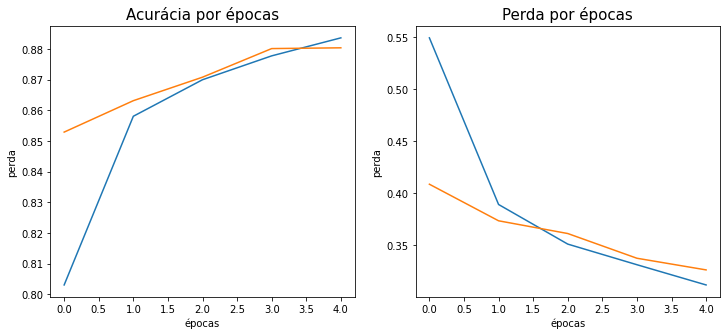

In [109]:
plot_accuracy_loss(historico)

#### Pesos aleatórios

In [110]:
pesos_camada_dense_aleatorios = np.random.rand(784, 256)
model.layers[1].set_weights([pesos_camada_dense_aleatorios, vieses_camada_dense])

In [111]:
model.compile(optimizer = 'adam', 
              loss = 'sparse_categorical_crossentropy', 
              metrics = ['accuracy'])
historico = model.fit(train_imgs, train_labels, epochs = 5, validation_split = 0.2)

Epoch 1/5
1500/1500 [==============================] - 8s 5ms/step - loss: 18.5027 - accuracy: 0.2099 - val_loss: 1.7957 - val_accuracy: 0.2790
Epoch 2/5
1500/1500 [==============================] - 7s 5ms/step - loss: 1.8988 - accuracy: 0.2357 - val_loss: 1.7410 - val_accuracy: 0.2962
Epoch 3/5
1500/1500 [==============================] - 7s 5ms/step - loss: 1.8788 - accuracy: 0.2405 - val_loss: 1.7673 - val_accuracy: 0.2637
Epoch 4/5
1500/1500 [==============================] - 7s 5ms/step - loss: 1.8813 - accuracy: 0.2400 - val_loss: 1.6916 - val_accuracy: 0.3010
Epoch 5/5
1500/1500 [==============================] - 8s 5ms/step - loss: 1.8673 - accuracy: 0.2477 - val_loss: 1.6855 - val_accuracy: 0.2875


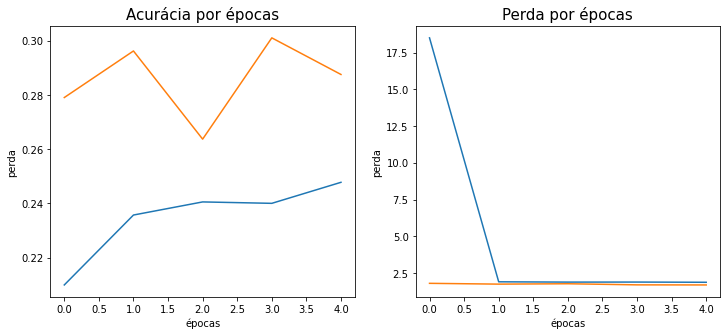

In [112]:
plot_accuracy_loss(historico)

### Alterando vieses "à mão"

#### Vieses e Pesos 0

In [113]:
vieses_camada_dense_zerados = np.zeros((256,))
model.layers[1].set_weights([pesos_camada_dense_zerados, vieses_camada_dense_zerados])

In [114]:
model.compile(optimizer = 'adam', 
              loss = 'sparse_categorical_crossentropy', 
              metrics = ['accuracy'])
historico = model.fit(train_imgs, train_labels, epochs = 5, validation_split = 0.2)

Epoch 1/5
1500/1500 [==============================] - 8s 5ms/step - loss: 2.3622 - accuracy: 0.1006 - val_loss: 2.3039 - val_accuracy: 0.0983
Epoch 2/5
1500/1500 [==============================] - 8s 5ms/step - loss: 2.3155 - accuracy: 0.0980 - val_loss: 2.3029 - val_accuracy: 0.1030
Epoch 3/5
1500/1500 [==============================] - 7s 5ms/step - loss: 2.3090 - accuracy: 0.1012 - val_loss: 2.3042 - val_accuracy: 0.1027
Epoch 4/5
1500/1500 [==============================] - 8s 5ms/step - loss: 2.3076 - accuracy: 0.1015 - val_loss: 2.3056 - val_accuracy: 0.1005
Epoch 5/5
1500/1500 [==============================] - 7s 5ms/step - loss: 2.3072 - accuracy: 0.0990 - val_loss: 2.3037 - val_accuracy: 0.0983


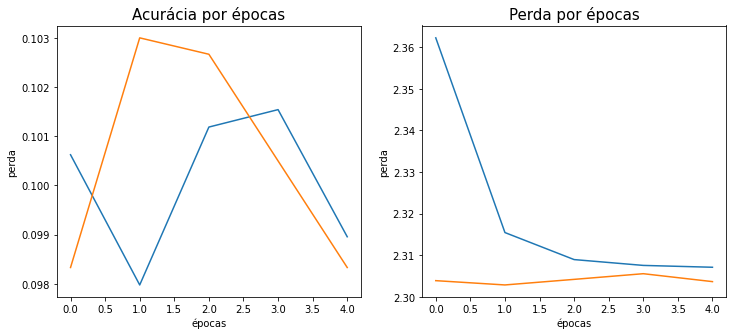

In [115]:
plot_accuracy_loss(historico)

#### Vieses 0 e Pesos aleatórios

Epoch 1/5
1500/1500 [==============================] - 8s 5ms/step - loss: 2.3976 - accuracy: 0.1000 - val_loss: 2.3279 - val_accuracy: 0.1003
Epoch 2/5
1500/1500 [==============================] - 7s 5ms/step - loss: 2.3108 - accuracy: 0.0979 - val_loss: 2.3035 - val_accuracy: 0.0957
Epoch 3/5
1500/1500 [==============================] - 8s 5ms/step - loss: 2.3029 - accuracy: 0.0980 - val_loss: 2.3028 - val_accuracy: 0.0957
Epoch 4/5
1500/1500 [==============================] - 8s 6ms/step - loss: 2.3028 - accuracy: 0.1004 - val_loss: 2.3026 - val_accuracy: 0.0995
Epoch 5/5
1500/1500 [==============================] - 8s 5ms/step - loss: 2.3028 - accuracy: 0.0973 - val_loss: 2.3028 - val_accuracy: 0.0983


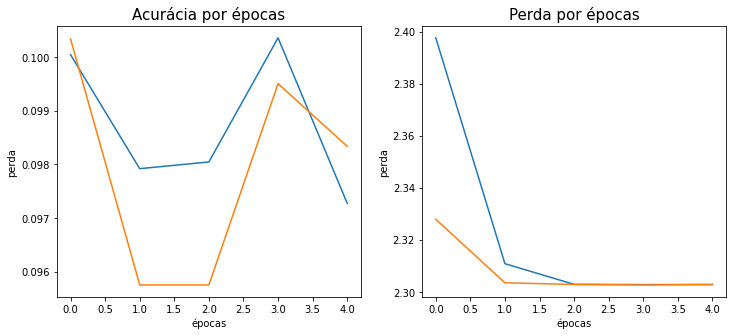

In [117]:
vieses_camada_dense_zerados = np.zeros((256,))
model.layers[1].set_weights([pesos_camada_dense_aleatorios, vieses_camada_dense_zerados])

model.compile(optimizer = 'adam', 
              loss = 'sparse_categorical_crossentropy', 
              metrics = ['accuracy'])
historico = model.fit(train_imgs, train_labels, epochs = 5, validation_split = 0.2)

plot_accuracy_loss(historico)

### Configurações do modelo

* **model.get_config()**: Retorna dicionários com todas as definições da rede e suas camadas.

In [72]:
model.get_config()['layers'][2]

{'class_name': 'Dense',
 'config': {'name': 'dense_29',
  'trainable': True,
  'dtype': 'float32',
  'units': 256,
  'activation': 'relu',
  'use_bias': True,
  'kernel_initializer': {'class_name': 'GlorotUniform',
   'config': {'seed': None}},
  'bias_initializer': {'class_name': 'Zeros', 'config': {}},
  'kernel_regularizer': None,
  'bias_regularizer': None,
  'activity_regularizer': None,
  'kernel_constraint': None,
  'bias_constraint': None}}

* O kernel_initializes é a função inicializa os pesos.

* A classe de inicialização dos pesos nesta rede foi a GlorotUniform, também chamada de Algoritmo de Xavier. Gera valores que não sejam nem muito grandes nem muito próximos de zero, de forma que evite atrapalhar a aprendizagem do modelo.

* A ReLu também azjuda a evitar valores extremos.

### Conclusões sobre Pesos e Vieses

* Os pesos influenciam mais no quanto uma rede aprende do que os vieses.
  * Os resultados foram piores quando os pesos foram inicializados aleatoriamente.

* É mais indicado inicializar os pesos de uma rede com zeros ou valores próximos de zero.

* O **bias_initializer** define como os pesos são inicializados. Na consulta acima, está definindo como 'Zeros', que é o padrão do Keras.

## Função ReLu

* $a = z^+ = max(0, z)$

* Não linear.

* A multiplicação da fução ReLu altera a inclinação da sua reta no 1º quadrante (x, y > 0).
* A soma desloca as retas no eixo y.